In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
seed = 2025 
np.random.seed(seed)

In [14]:
events = pd.read_csv("data/events.csv")

# Convert time and depth columns
events["time"] = pd.to_datetime(events["time"])
events["depth"] = events["depth"].astype(str).str.replace("Depth: ","").astype(float)

#Make data numerical:
events["horizontalError"] = events["horizontalError"].map({"Unknown":0,"Shallow":1,"Deep":2})
labelencoder = LabelEncoder() #initializing an object of class LabelEncoder
events['type'] = labelencoder.fit_transform(events['type']) 
events['net'] = labelencoder.fit_transform(events['net'])
events["is_country"] = events["is_country"].map({False:0,True:1})
events["date"] = events["time"].dt.date

# Splitting the data
events = events[events["mag"].notna()]
# Data prep on training dataset:
#print(events.isna().sum())
events["dmin"] = events["dmin"].fillna(events["dmin"].mean()) # Fill with mean
events = events.drop(columns=["id"]) # Drop id, we don't need it for training

In [15]:
# Load and preprocess weather data
weather = pd.read_csv("data/weather.csv")
# Convert time column and create date column
weather["time"] = pd.to_datetime(weather["time"])
weather["date"] = weather["time"].dt.date
# Make weather daily data by grouping
grouped_weather = weather.groupby(["lat","lng","date"]).agg({"temperature":"mean",
                                                             "humidity":"mean",
                                                             "precipitation":"sum",
                                                             "sealevelPressure":"mean",
                                                             "surfacePressure":"mean",
                                                             "nst":"min"}).reset_index()
# Fill missing values
grouped_weather['nst'] = grouped_weather["nst"].fillna(0)

In [16]:
# Join the weather data and the event data:
merged_df = pd.merge(events,grouped_weather,how="left",left_on=["date","latitude","longitude"],right_on=["date","lat","lng"])

In [17]:
# setting label
merged_df["is_high_magnitude"] = merged_df["mag"]>4.4
merged_df["is_high_magnitude"] = merged_df["is_high_magnitude"].map({False:0,True:1})

# Drop columns we don't need
unneeded_columns = ["mag","magError","time","date","lat","lng","index"]
merged_df = merged_df.drop(columns=unneeded_columns)

In [18]:
# Train test split
test_size = 0.2
k = 6 # k-fold Cross-validation

y_name = "is_high_magnitude" # Name of prediction column


X = merged_df.drop(columns=[y_name])
y = merged_df[y_name] 

df_train, df_test = train_test_split(merged_df, test_size=test_size, stratify=merged_df[y_name], random_state=seed)

print(f"Proportions Train:\n {df_train[y_name].value_counts(normalize=True)}")
print(f"Proportions Test:\n {df_train[y_name].value_counts(normalize=True)}")

Proportions Train:
 is_high_magnitude
0    0.725525
1    0.274475
Name: proportion, dtype: float64
Proportions Test:
 is_high_magnitude
0    0.725525
1    0.274475
Name: proportion, dtype: float64


In [19]:
train_model = LogisticRegression(random_state=seed, max_iter=10_000_000)

# Fit the model
# Cross-validation
X_train, y_train = df_train.drop(columns=[y_name]), df_train[y_name]
cv_fits_accuracy = cross_val_score(train_model, X_train, y_train, cv=k, scoring='accuracy')
cv_fits_precision = cross_val_score(train_model, X_train, y_train, cv=k, scoring='precision')
cv_fits_recall = cross_val_score(train_model, X_train, y_train, cv=k, scoring='recall')

print("\nCV-Accuracy:", np.mean(cv_fits_accuracy))
print("CV-Precision:", np.mean(cv_fits_precision))
print("CV-Recall:", np.mean(cv_fits_recall))

# Train the final model
train_model.fit(df_train.drop(columns=[y_name]), df_train[y_name])

# Apply on test set
test_predictions = train_model.predict(df_test.drop(columns=[y_name]))
test_probabilities = train_model.predict_proba(df_test.drop(columns=[y_name]))

test_predictions_df = pd.DataFrame({'Churn': df_test[y_name],
                                     'Predicted_Churn': test_predictions,
                                     'Probability_Churn=0': test_probabilities[:, 0],
                                     'Probability_Churn=1': test_probabilities[:, 1]})

# Confusion Matrix
conf_matrix = confusion_matrix(df_test[y_name], test_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall

print("\nTest-Precision:", precision_score(df_test[y_name], test_predictions))
print("Test-Accuracy:", accuracy_score(df_test[y_name], test_predictions))
print("Test-Recall:", recall_score(df_test[y_name], test_predictions))


CV-Accuracy: 0.8698560999645989
CV-Precision: 0.803191164538442
CV-Recall: 0.696702516011979

Confusion Matrix:
[[1471   77]
 [ 162  423]]

Test-Precision: 0.846
Test-Accuracy: 0.8879512423816222
Test-Recall: 0.7230769230769231


<Axes: >

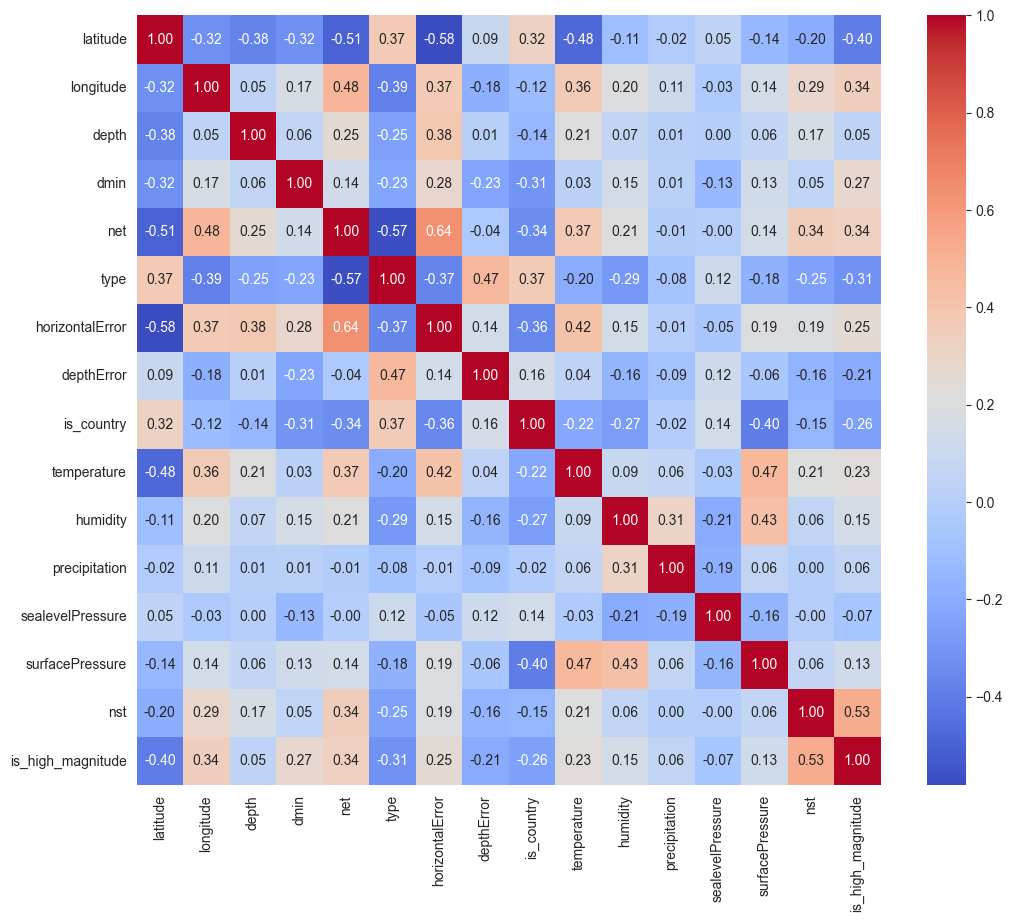

In [20]:
# Print multicollinearity 
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

In [21]:
# See p-values of features
import statsmodels.api as sm
X_with_const = sm.add_constant(X)
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()
print(result.summary())
# Try test set predictions to verify
test_set_predictions = train_model.predict(df_test.drop(columns=[y_name]))
print("\nTest-Precision:", precision_score(df_test[y_name], test_set_predictions))
print("Test-Accuracy:", accuracy_score(df_test[y_name], test_set_predictions))
print("Test-Recall:", recall_score(df_test[y_name], test_set_predictions))


Optimization terminated successfully.
         Current function value: 0.290058
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:      is_high_magnitude   No. Observations:                10662
Model:                          Logit   Df Residuals:                    10646
Method:                           MLE   Df Model:                           15
Date:                Mon, 20 Oct 2025   Pseudo R-squ.:                  0.5064
Time:                        11:27:32   Log-Likelihood:                -3092.6
converged:                       True   LL-Null:                       -6265.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.0502      4.577     -1.759      0.079     -17.022       0.921
latitude  